# 05 - Full Head Example

We have so far covered most of the main functionalities of the package. In this tutorial, we will repeat what we did in the past tutorial, but in a more realistic context: the human brain. By end of the tutorial you should have a good understanding of what it takes to simulate photon propagation in a human head.

The head we use here is a pre-segmented ICBM152 head atlas. Together with the optode placement, they are shipped with the [NeuroDOT](https://github.com/WUSTL-ORL/NeuroDOT_py) package/toolbox developed by the Optical Radiology Labs at WUSTL. They were loaded, restructured, and saved as .mat files.

After constructing the head model, we will use it for something really exciting: DOT reconstruction of a human retinotopy dataset. For this, we will use the CCW1 dataset from the NeuroDOT package, and follow the pipelines provided in NeuroDOT. The reader is strongly recommended to also have a closer look at the original tutorial [here](https://github.com/WUSTL-ORL/NeuroDOT_py/blob/main/Pipelines/NeuroDOT_Full_Processing_Notebook.ipynb).


In [8]:
import sys
sys.path.insert(1, '../')
import nirfasterff as ff # ff is short for fast and furious
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio

In [4]:
# load the 3D volume
# Note that the data type must be uint8
vol = sio.loadmat('headvol.mat')['mask']
# Load the optode information. This is the example 24x28 pad in NeuroDOT
tmp = sio.loadmat('optode_information.mat')
link = tmp['link']
srcpos = tmp['srcpos']
detpos = tmp['detpos']

In [6]:
# define the parameters for the mesh and the optodes
params = ff.utils.MeshingParams()
params.offset = np.array([-87., -124.,  -76.5])
params.facet_distance = 0.75
params.facet_size = 0.75
params.general_cell_size = 2.0
params.subdomain = np.array([[1, 1.5],
                            [3, 1.5],
                            [5, 1.5]])

# optical property at 850nm
# 1: csf; 2: white; 3: gray; 4: bone; 5: skin
optical_props = np.array([[1, 0.004, 0.3, 1.4],
                [2, 0.0208, 1.0107, 1.4],
                [3, 0.0192, 0.6726, 1.4],
                 [4, 0.0139, 0.84, 1.4],
                 [5, 0.0190, 0.64, 1.4]])

# optodes
sources = ff.base.optode(srcpos)
detectors = ff.base.optode(detpos)

# create the mesh
mesh = ff.base.stndmesh()
mesh.from_volume(vol, param=params, prop=optical_props, src=sources, det=detectors, link=link)

Running CGAL mesher
Meshing...

Running Lloyd smoothing... (up to 120s)

Running local optimization...

Converting to NIRFAST format


(<Figure size 640x480 with 2 Axes>, <Axes3D: >)

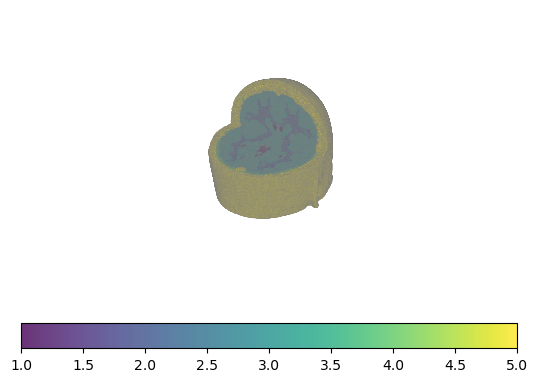

In [11]:
# let's have a look
ff.visualize.plot3dmesh(mesh, mesh.region, '(y>0) | (z<0)')

As you can see, we just generated a rather dense mesh. Depending on your computer's CPU power, that could have taken a while. However, this is in general the quality of the mesh you need for accurate DOT reconstruction. 

Now let's generate some forward data.

In [15]:
# define the grid space
xgrid = np.arange(-87., 88., 2.)
ygrid = np.arange(-120., 40., 2.)
zgrid = np.arange(-75., 100., 2.)
# This can take a few seconds and is heavily bottlenecked by CPU
mesh.gen_intmat(xgrid, ygrid, zgrid)

In [16]:
# cw data
data = mesh.femdata(0)[0]

/var/folders/x8/cr7bc06s70z4snmwjhnncdkw0000gn/T/ipykernel_22407/3587072073.py:3: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(data.phi[:,32,:,12]).squeeze().T, origin='lower')


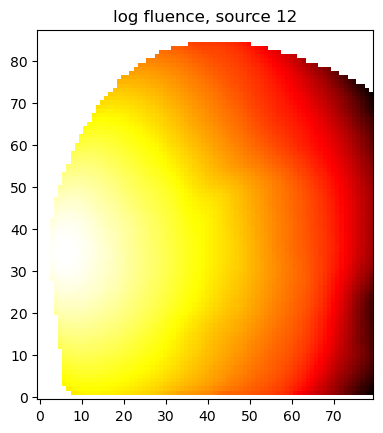

In [23]:
# now have a look
plt.set_cmap('hot')
plt.imshow(np.log(data.phi[:,32,:,12]).squeeze().T, origin='lower')
plt.title('log fluence, source 12')
plt.show()

Finally, let's save the mesh

In [24]:
mesh.save_nirfast('headmesh')

Now let's use the created head model for an actual reconstruction application. First, let's load the NeuroDOTpy package. Be noted, that NeuroDOTpy is most optimized for Python 3.8, as of Sep 2025. 

In [4]:
import sys
sys.path.insert(1, '../../../NeuroDOT_py/src') # this is how it's set up on my machine. modify accordingly
import neuro_dot as ndot

Now we can load the data and run the pre-processing pipeline. Essentially, the data is first converted to log intensity changes ($\Delta OD$), which is used to mark good channels (low variance, and low [GVTD](https://doi.org/10.1002/hbm.25111)). Data is subsequently linear-detrended and bandpass filtered, before the superficial signal regression step. Finally, data is resampled to 1Hz, which is the rotating speed of the checkerboard pattern. This way, very conveniently, each frame in data corresponds exactly to one angular position of the checkerboard. The details of the experiment itself can be found in [this paper](https://doi.org/10.1016/j.neuroimage.2012.01.124) as well as the relevant cited papers therein.

In [6]:
# Load and process data
data_path = '../../../NeuroDOT_py/Data/NeuroDOT_Data_Sample_CCW1.mat'
data = ndot.loadmat(data_path)['data']     
__info = ndot.loadmat(data_path)['info']             # adding __info makes info private, so any changes will be function-specific

lmdata = ndot.logmean(data)[0]                                    # Logmean Light Levels
info = ndot.FindGoodMeas(lmdata, __info, 0.075)                    # Detect Noisy Channels
gvtd = ndot.CalcGVTD(lmdata)
info['GVTD'] = gvtd
lmdata = ndot.detrend_tts(lmdata)      
hpdata = ndot.highpass(lmdata, .02, info['system']['framerate'])  # High Pass Filter (0.02 Hz)
lp1data = ndot.lowpass(hpdata, 1, info['system']['framerate'])    # Low Pass Filter 1 (1.0 Hz)
hem = ndot.gethem(lp1data, info)                                  # Superficial Signal Regression
lp1data, _ = ndot.regcorr(lp1data, info, hem)
lp2data = ndot.lowpass(lp1data, 0.2, info['system']['framerate']) # Low Pass Filter 2 (0.5 Hz)
resample_data, info = ndot.resample_tts(lp2data, info, 1, 1e-5)   # 1 Hz Resampling (1 Hz)

2381 25702


Let's load the previously created head model (or directly use it if you have been following this tutorial all along), and create the Jacobian matrix. Rememer two things: 1) optical properties are already set for 850nm, and 2) we only need to calculate the Jacobian matrix for the posterior part of the head, because our optode grid is not sensitive to elsewhere.

In [9]:
# Now calculate the Jacobian
mesh = ff.base.stndmesh()
mesh.from_file('headmesh')
mesh.touch_optodes()
xgrid = np.arange(-65., 68., 2.)
ygrid = np.arange(-119., -72., 2.)
zgrid = np.arange(-29., 52., 2.)
mesh.gen_intmat(xgrid, ygrid, zgrid)
A850 = mesh.jacobian(0)[0]
# nirfasterff uses xyz coordinates, need to convert to ijk to be compatible with neurodot
for i in range(672):
    A850[i,:]=np.reshape(np.transpose(np.reshape(A850[i,:], (24,67,41),order='F'),[1,0,2]),24*67*41,order='F')

Sources integration functions loaded
Detectors integration functions loaded
touching sources
touching detectors
Calculating direct field...
Calculating adjoint field...
Integrating...


/home/jiaming/Documents/Work/Research/nirfastff/NIRFASTerPy/tutorials/../nirfasterff/math.py:759: RuntimeWarning:

invalid value encountered in divide



Let's change the optical properties to what's appropriate for 750nm, and repeat.

In [10]:
# repeat for 750nm
# csf properties don't change, skip
mesh.change_prop(np.argwhere(mesh.region==2), [0.0167, 1.1908, 1.4])
mesh.change_prop(np.argwhere(mesh.region==3), [0.0180, 0.8359, 1.4])
mesh.change_prop(np.argwhere(mesh.region==4), [0.0116, 0.94, 1.4])
mesh.change_prop(np.argwhere(mesh.region==5), [0.0170, 0.74, 1.4])
# move the optodes again - probably doesn't make a difference but just to be safe
mesh.touch_optodes()
A750 = mesh.jacobian(0)[0]
# nirfasterff uses xyz coordinates, need to convert to ijk to be compatible with neurodot
for i in range(672):
    A750[i,:]=np.reshape(np.transpose(np.reshape(A750[i,:], (24,67,41),order='F'),[1,0,2]),24*67*41,order='F')

touching sources
touching detectors
Calculating direct field...
Calculating adjoint field...
Integrating...


Now set up some auxiliary variables. infoA mimics what would be available in an MRI header file, containing the volumetric information. It is to be used for interpolation steps in a later stage. keep750 and keep850 marks channels with reasonably short source-detector separation (<=40mm) and low noise.

In [11]:
infoA={'mmppix':[-2,-2,-2],'nVx':67,'nVy':24,'nVz':41,
       'center':np.array([-69,70,-54]), 'sV':2, 'Good_Vox':np.arange(67*24*41)+1} # voxelize only the back side of the brain

keep750 = np.logical_and(np.where(info['pairs']['r2d'] <= 40,1,0), info['MEAS']['GI'])[:672]
keep850 = np.logical_and(np.where(info['pairs']['r2d'] <= 40,1,0), info['MEAS']['GI'])[672:]

Inverse Jacobian, smooth it with a Gaussian kernel, and apply it to data. Done for two wavelengths. Here we use the Tikhonov function in NeuroDOT as it's more convenient for this application.

In [12]:
Nvox = A850.shape[1]
Nt = resample_data.shape[1]
cortex_mu_a = np.zeros((Nvox,Nt,2))

iA = ndot.Tikhonov_invert_Amat(A750[keep750,:], 0.01, 0.1)                 # Invert A-Matrix
iA = ndot.smooth_Amat(iA, infoA, 2)                  # Smooth Inverted A-Matrix      
cortex_mu_a[:, :, 0] = ndot.reconstruct_img(resample_data[:672][keep750, :], iA)  # Reconstruct Image Volume 
# repeat for 850nm
iA = ndot.Tikhonov_invert_Amat(A850[keep850,:], 0.01, 0.1)                 # Invert A-Matrix
iA = ndot.smooth_Amat(iA, infoA, 2)                  # Smooth Inverted A-Matrix      
cortex_mu_a[:, :, 1] = ndot.reconstruct_img(resample_data[672:][keep850, :], iA)

Convert to hemoglobins using Beer's law, and block average.

In [13]:
E = np.array([[1.6348, 3.143 ], 
              [2.119 , 1.61  ]])   # extinction coefficients
# Beer-Lambert law
cortex_Hb = ndot.spectroscopy_img(cortex_mu_a, E) 
cortex_HbO = cortex_Hb[:, :, 0]

badata_HbO = ndot.BlockAverage(cortex_HbO, info['paradigm']['synchpts'][info['paradigm']['Pulse_2']-1], 36)[0]
badata_HbO= badata_HbO - badata_HbO[:,0, None]
badata_HbOvol = ndot.GoodVox2vol(badata_HbO, infoA)

/home/jiaming/Documents/Work/Research/nirfastff/NIRFASTerPy/tutorials/../../../NeuroDOT_py/src/neuro_dot/Analysis.py:67: RuntimeWarning:

invalid value encountered in divide



Coregister with structural scan, and plot the slices.

PlotSlices is active - [Left mouse] to navigate and [Middle mouse] to exit.


/home/jiaming/Documents/Work/Research/nirfastff/NIRFASTerPy/tutorials/../../../NeuroDOT_py/src/neuro_dot/Visualizations.py:371: RuntimeWarning:

invalid value encountered in cast

/home/jiaming/Documents/Work/Research/nirfastff/NIRFASTerPy/tutorials/../../../NeuroDOT_py/src/neuro_dot/Visualizations.py:3683: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



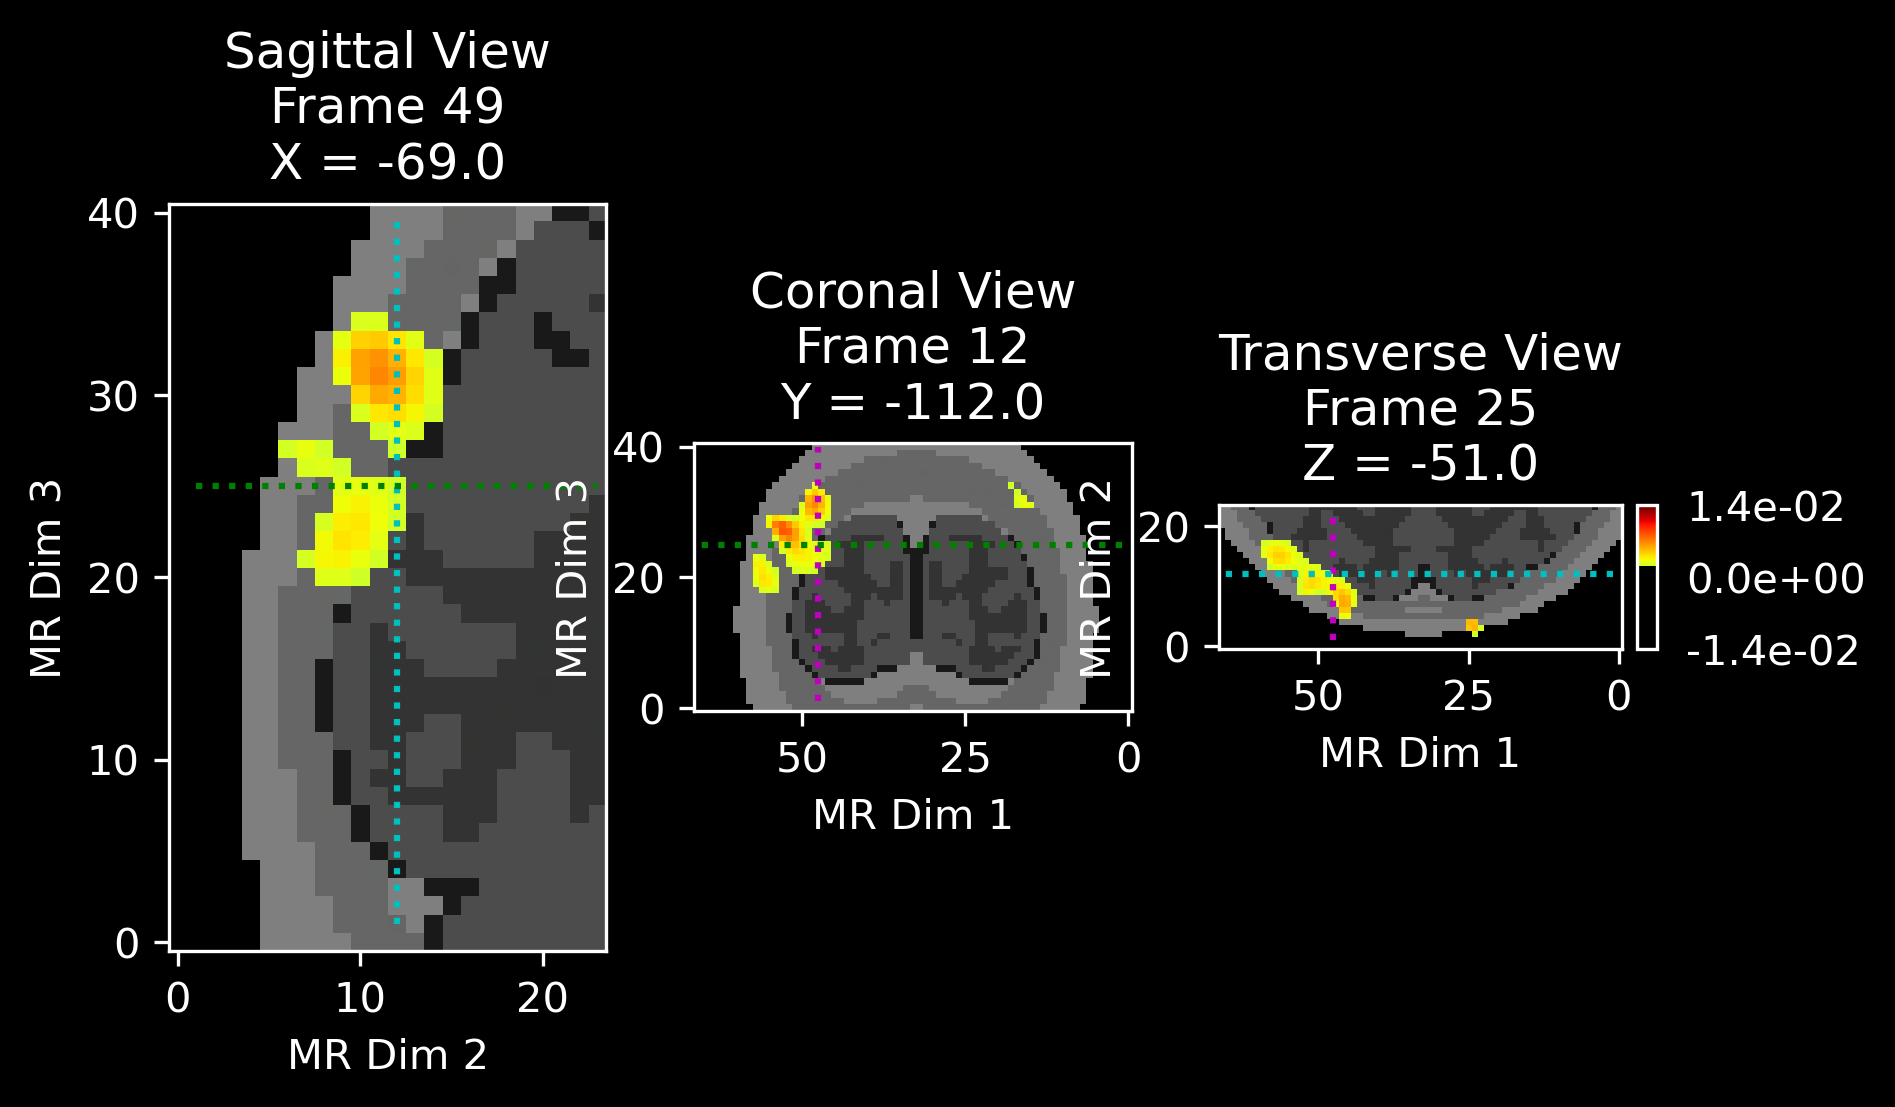

In [14]:
MNI_file = '../../../NeuroDOT_py/Support Files/Atlases/Segmented_MNI152nl_on_MNI111_py'
MNI = ndot.loadmat(MNI_file)['vol'] # load MNI atlas (same data set as in A matrix dim)
infoB = ndot.loadmat(MNI_file)['h']
MNI_dim = ndot.affine3d_img(MNI, infoB, infoA, affine =np.eye(4), interp_type ='nearest')
# View in volume space
fig = plt.figure(facecolor='k', dpi=300)
Params_recon = {}
Params_recon['Th'] = {}
Params_recon['Scale']=0.8*np.amax(abs(badata_HbOvol))
Params_recon['Th']['P']= 0.2*Params_recon['Scale']
Params_recon['Th']['N']= -np.inf
Params_recon['Cmap']='jet'
Params_recon['slices'] = [49,12,25]
Params_recon['fig_handle']=fig

ndot.PlotSlices(MNI_dim, infoB, params = Params_recon, overlay = badata_HbOvol[:,:,:,16].squeeze())

Finally, let's do something prettier: project reconstruction to the cortical surface, and view from the posterior. Ploty engine is used.

In [16]:
# Now project the reconstruction onto the cortical surface
MNI_path = '../../../NeuroDOT_py/Support Files/Cortical Meshes/MNI164k_big_py'
MNIl=ndot.loadmat(MNI_path)['MNIl']
MNIr=ndot.loadmat(MNI_path)['MNIr']

HbO_atlas = ndot.affine3d_img(np.flip(badata_HbOvol,axis=0),infoA, infoB, np.eye(4))
HbO_atlas = np.transpose(HbO_atlas,[1,2,3,0])
tp_Eg_atlas = np.squeeze(HbO_atlas[:,:,:,16])

pS = Params_recon
pS['view'] = 'post'
pS['ctx'] = 'std'
pS['Scale']=0.5*np.amax(abs(badata_HbOvol))
pS['Th']['P']=0.2*Params_recon['Scale']
pS['Th']['N']=-np.inf
mapL, mapR, fig, params2 = ndot.PlotInterpSurfMesh(tp_Eg_atlas, MNIl, MNIr, infoB, pS)
fig.write_image('humanrecon_cortex.svg')

/home/jiaming/Documents/Work/Research/nirfastff/NIRFASTerPy/tutorials/../../../NeuroDOT_py/src/neuro_dot/Visualizations.py:371: RuntimeWarning:

invalid value encountered in cast

/home/jiaming/anaconda3/envs/py12/lib/python3.12/site-packages/plotly/offline/offline.py:556: UserWarning:

Your filename `PLRM_fig_2025_09_25_13_15_21` didn't end with .html. Adding .html to the end of your file.



That's it for now!